<a href="https://colab.research.google.com/github/SachinSharma-2003/Oil_Spill_Detection-/blob/main/ProjectEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

os.makedirs("dataset/images/train", exist_ok=True)
os.makedirs("dataset/images/val", exist_ok=True)
os.makedirs("dataset/masks/train", exist_ok=True)
os.makedirs("dataset/masks/val", exist_ok=True)

print("Folders created successfully")

Folders created successfully


In [3]:
import os

print(os.listdir('.'))


['.config', 'unet_oil_spill_model.h5', 'dataset', 'processed', 'drive', 'sample_data']


In [4]:
import os
for f in os.listdir('.'):
    print(f, os.path.getsize(f))


.config 4096
unet_oil_spill_model.h5 93509224
dataset 4096
processed 4096
drive 4096
sample_data 4096


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract the dataset


In [6]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/images.zip", "r") as z:
    z.extractall("/content/dataset")

with zipfile.ZipFile("/content/drive/MyDrive/masks.zip", "r") as z:
    z.extractall("/content/dataset")


In [7]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(root, "->", len(files), "files")


/content/dataset -> 0 files
/content/dataset/images -> 1 files
/content/dataset/images/train -> 6455 files
/content/dataset/images/val -> 1615 files
/content/dataset/masks -> 1 files
/content/dataset/masks/train -> 6455 files
/content/dataset/masks/val -> 1615 files
/content/dataset/__MACOSX -> 2 files
/content/dataset/__MACOSX/images -> 3 files
/content/dataset/__MACOSX/images/train -> 6455 files
/content/dataset/__MACOSX/images/val -> 1615 files
/content/dataset/__MACOSX/masks -> 3 files
/content/dataset/__MACOSX/masks/train -> 6455 files
/content/dataset/__MACOSX/masks/val -> 1615 files


In [8]:
import shutil

shutil.rmtree("/content/dataset/__MACOSX", ignore_errors=True)

print("Removed __MACOSX folder successfully!")


Removed __MACOSX folder successfully!


In [9]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(root, "->", len(files), "files")


/content/dataset -> 0 files
/content/dataset/images -> 1 files
/content/dataset/images/train -> 6455 files
/content/dataset/images/val -> 1615 files
/content/dataset/masks -> 1 files
/content/dataset/masks/train -> 6455 files
/content/dataset/masks/val -> 1615 files


In [10]:
import os

removed = 0
for root, dirs, files in os.walk("/content/dataset"):
    for f in files:
        if f == ".DS_Store":
            os.remove(os.path.join(root, f))
            removed += 1

print("Removed .DS_Store:", removed)


Removed .DS_Store: 2


In [11]:
from glob import glob

train_images = sorted(glob("/content/dataset/images/train/*.png"))
val_images   = sorted(glob("/content/dataset/images/val/*.png"))

train_masks  = sorted(glob("/content/dataset/masks/train/*.png"))
val_masks    = sorted(glob("/content/dataset/masks/val/*.png"))

print("Train Images:", len(train_images))
print("Train Masks :", len(train_masks))
print("Val Images  :", len(val_images))
print("Val Masks   :", len(val_masks))


Train Images: 6455
Train Masks : 6455
Val Images  : 1615
Val Masks   : 1615


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random


In [13]:
train_images = sorted(glob("/content/dataset/images/train/*.png"))
train_masks  = sorted(glob("/content/dataset/masks/train/*.png"))

val_images   = sorted(glob("/content/dataset/images/val/*.png"))
val_masks    = sorted(glob("/content/dataset/masks/val/*.png"))

print("Train Images:", len(train_images))
print("Train Masks :", len(train_masks))
print("Val Images  :", len(val_images))
print("Val Masks   :", len(val_masks))


Train Images: 6455
Train Masks : 6455
Val Images  : 1615
Val Masks   : 1615


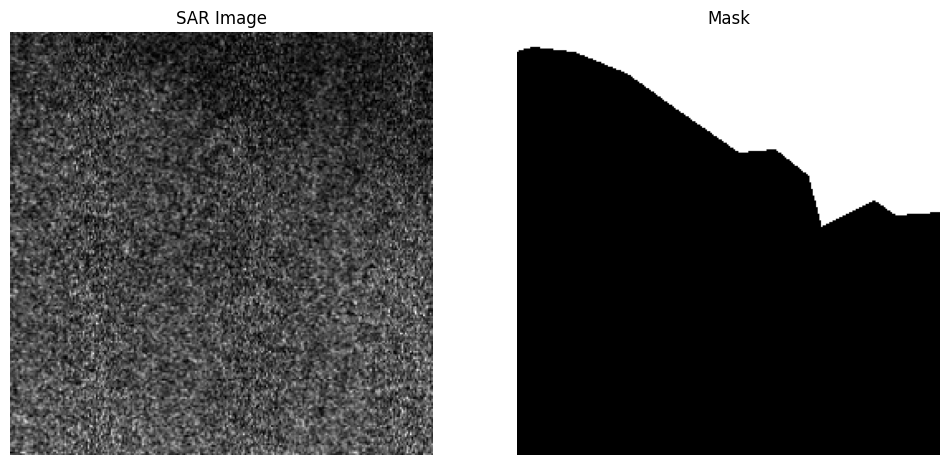

In [14]:
idx = random.randint(0, len(train_images)-1)

img  = cv2.imread(train_images[idx], 0)
mask = cv2.imread(train_masks[idx], 0)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("SAR Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()


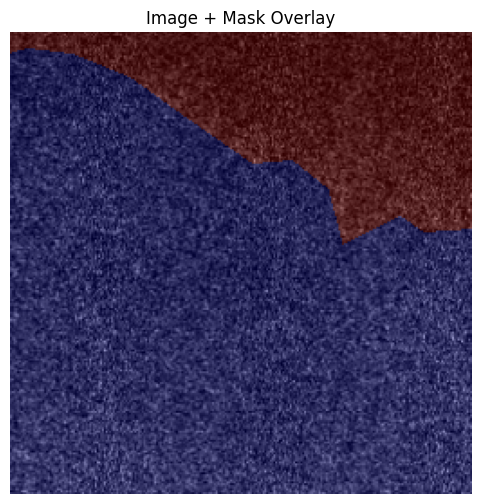

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='jet', alpha=0.4)
plt.title("Image + Mask Overlay")
plt.axis('off')
plt.show()


In [16]:
print("Image Min :", img.min())
print("Image Max :", img.max())
print("Image Mean:", img.mean())


Image Min : 0
Image Max : 248
Image Mean: 66.00250244140625


In [17]:
print("Mask unique values:", np.unique(mask))


Mask unique values: [  0 255]


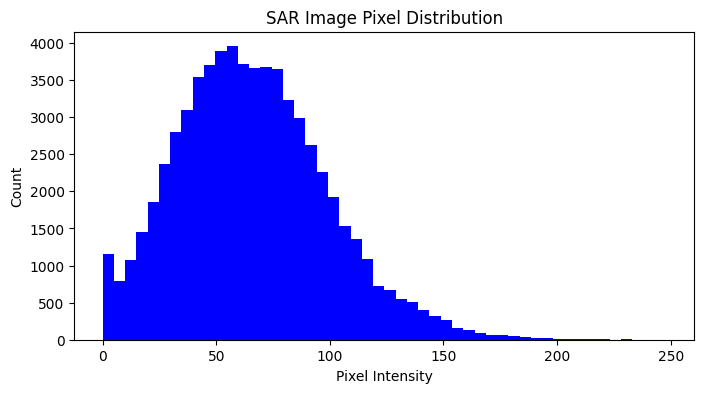

In [18]:
plt.figure(figsize=(8,4))
plt.hist(img.ravel(), bins=50, color='blue')
plt.title("SAR Image Pixel Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.show()


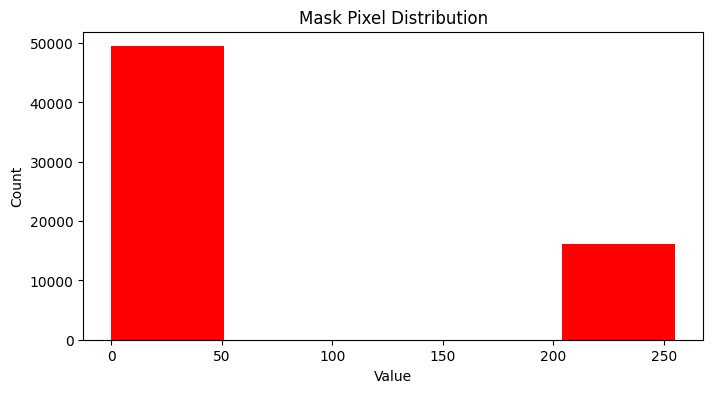

In [19]:
plt.figure(figsize=(8,4))
plt.hist(mask.ravel(), bins=5, color='red')
plt.title("Mask Pixel Distribution")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


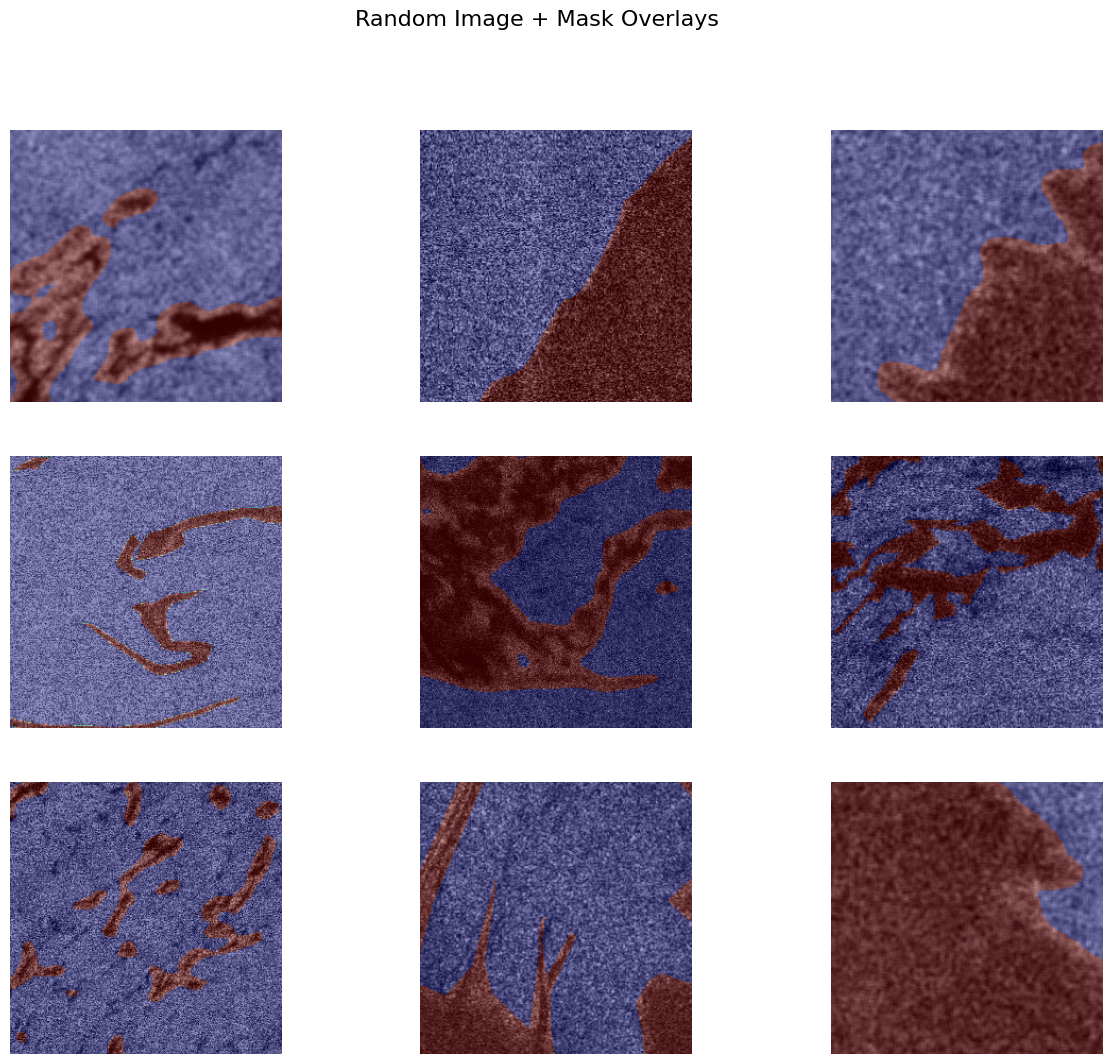

In [20]:
plt.figure(figsize=(15,12))

for i in range(9):
    idx = random.randint(0, len(train_images)-1)

    img  = cv2.imread(train_images[idx], 0)
    mask = cv2.imread(train_masks[idx], 0)

    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.4)
    plt.axis('off')

plt.suptitle("Random Image + Mask Overlays", fontsize=16)
plt.show()


In [21]:
print("Training image shape:", img.shape)


Training image shape: (256, 256)


In [22]:
total_oil_pixels = 0
total_pixels = 0

for m in train_masks:
    mask = cv2.imread(m, 0)
    total_oil_pixels += np.sum(mask > 0)
    total_pixels += mask.size

oil_percentage = (total_oil_pixels / total_pixels) * 100
print(f"Oil Pixel Percentage in Training Masks: {oil_percentage:.4f}%")


Oil Pixel Percentage in Training Masks: 25.6900%


In [23]:
print("Training samples:", len(train_images))
print("Validation samples:", len(val_images))


Training samples: 6455
Validation samples: 1615


In [24]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt


In [25]:
train_images = sorted(glob("/content/dataset/images/train/*.png"))
train_masks  = sorted(glob("/content/dataset/masks/train/*.png"))

print("Loaded", len(train_images), "train images")
print("Loaded", len(train_masks),  "train masks")


Loaded 6455 train images
Loaded 6455 train masks


In [26]:
os.makedirs("/content/processed/train/images", exist_ok=True)
os.makedirs("/content/processed/train/masks", exist_ok=True)

os.makedirs("/content/processed/val/images", exist_ok=True)
os.makedirs("/content/processed/val/masks", exist_ok=True)


In [27]:
IMG_SIZE = 256  # recommended for U-Net

def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # 1. Remove speckle noise (SAR)
    img = cv2.medianBlur(img, 3)

    # 2. Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # 3. Normalize (0-1)
    img = img / 255.0

    return img

def preprocess_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # 1. Resize
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    # 2. Binarize mask (0 or 1)
    mask = (mask > 0).astype(np.uint8)

    return mask


In [28]:
for img_path, mask_path in zip(train_images, train_masks):
    img = preprocess_image(img_path)
    mask = preprocess_mask(mask_path)

    # save preprocessed outputs
    img_name = os.path.basename(img_path)
    mask_name = os.path.basename(mask_path)

    np.save(f"/content/processed/train/images/{img_name}.npy", img)
    np.save(f"/content/processed/train/masks/{mask_name}.npy", mask)


In [29]:
for img_path, mask_path in zip(val_images, val_masks):
    img = preprocess_image(img_path)
    mask = preprocess_mask(mask_path)

    img_name = os.path.basename(img_path)
    mask_name = os.path.basename(mask_path)

    np.save(f"/content/processed/val/images/{img_name}.npy", img)
    np.save(f"/content/processed/val/masks/{mask_name}.npy", mask)


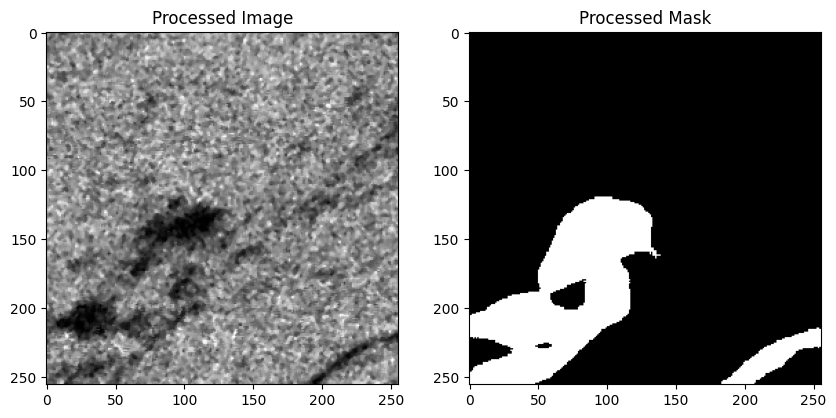

In [30]:
import random

sample = random.choice(glob("/content/processed/train/images/*.npy"))

img = np.load(sample)
mask = np.load(sample.replace("images", "masks"))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Processed Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Processed Mask")

plt.show()


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
from glob import glob


In [32]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [33]:
# Load training data
X_train = np.array([np.load(p) for p in sorted(glob("/content/processed/train/images/*.npy"))])
y_train = np.array([np.load(p) for p in sorted(glob("/content/processed/train/masks/*.npy"))])

# Load validation data
X_val = np.array([np.load(p) for p in sorted(glob("/content/processed/val/images/*.npy"))])
y_val = np.array([np.load(p) for p in sorted(glob("/content/processed/val/masks/*.npy"))])

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)

Train: (6455, 256, 256) (6455, 256, 256)
Val  : (1615, 256, 256) (1615, 256, 256)


In [34]:
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]

y_train = y_train[..., np.newaxis]
y_val   = y_val[..., np.newaxis]

print(X_train.shape, y_train.shape)

(6455, 256, 256, 1) (6455, 256, 256, 1)


In [35]:
# 1️⃣ Enable mixed precision FIRST
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# 2️⃣ Then define the U-Net model
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    # 🔴 Output must be float32
    outputs = layers.Conv2D(
        1, 1, activation='sigmoid', dtype='float32'
    )(c7)

    model = models.Model(inputs, outputs)
    return model

# 3️⃣ Then compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model = unet_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
loss = BinaryCrossentropy()

In [37]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
X_train_small = X_train[:500]
y_train_small = y_train[:500]

X_val_small = X_val[:100]
y_val_small = y_val[:100]

In [39]:
history = model.fit(
    X_train_small, y_train_small,
    validation_data=(X_val_small, y_val_small),
    epochs=2,
    batch_size=8
)

Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 731ms/step - accuracy: 0.8417 - loss: 0.4884 - val_accuracy: 0.8327 - val_loss: 0.3366
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.8609 - loss: 0.2915 - val_accuracy: 0.9188 - val_loss: 0.2178


In [40]:
model.save("/content/unet_oil_spill_model.h5")
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


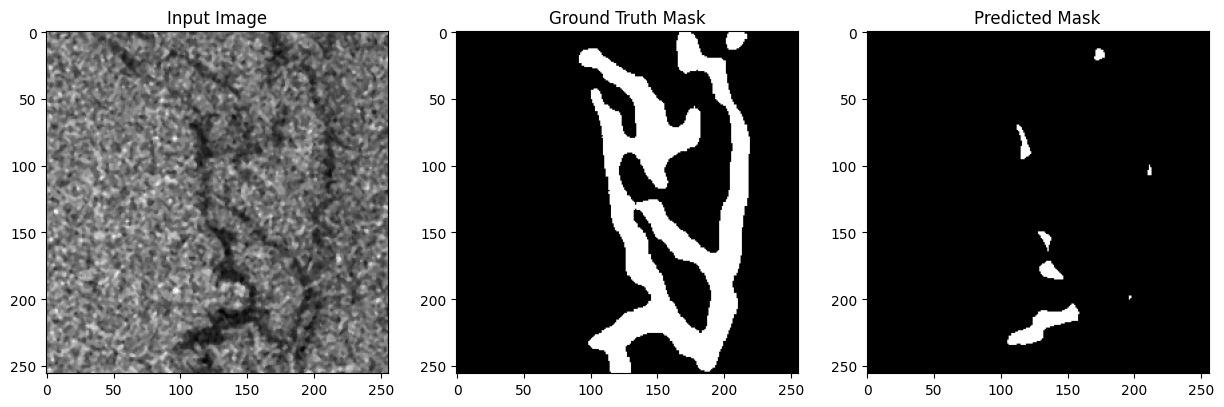

In [41]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(X_val)-1)

pred = model.predict(X_val[idx:idx+1])[0]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(X_val[idx].squeeze(), cmap='gray')
plt.title("Input Image")

plt.subplot(1,3,2)
plt.imshow(y_val[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred.squeeze() > 0.5, cmap='gray')
plt.title("Predicted Mask")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


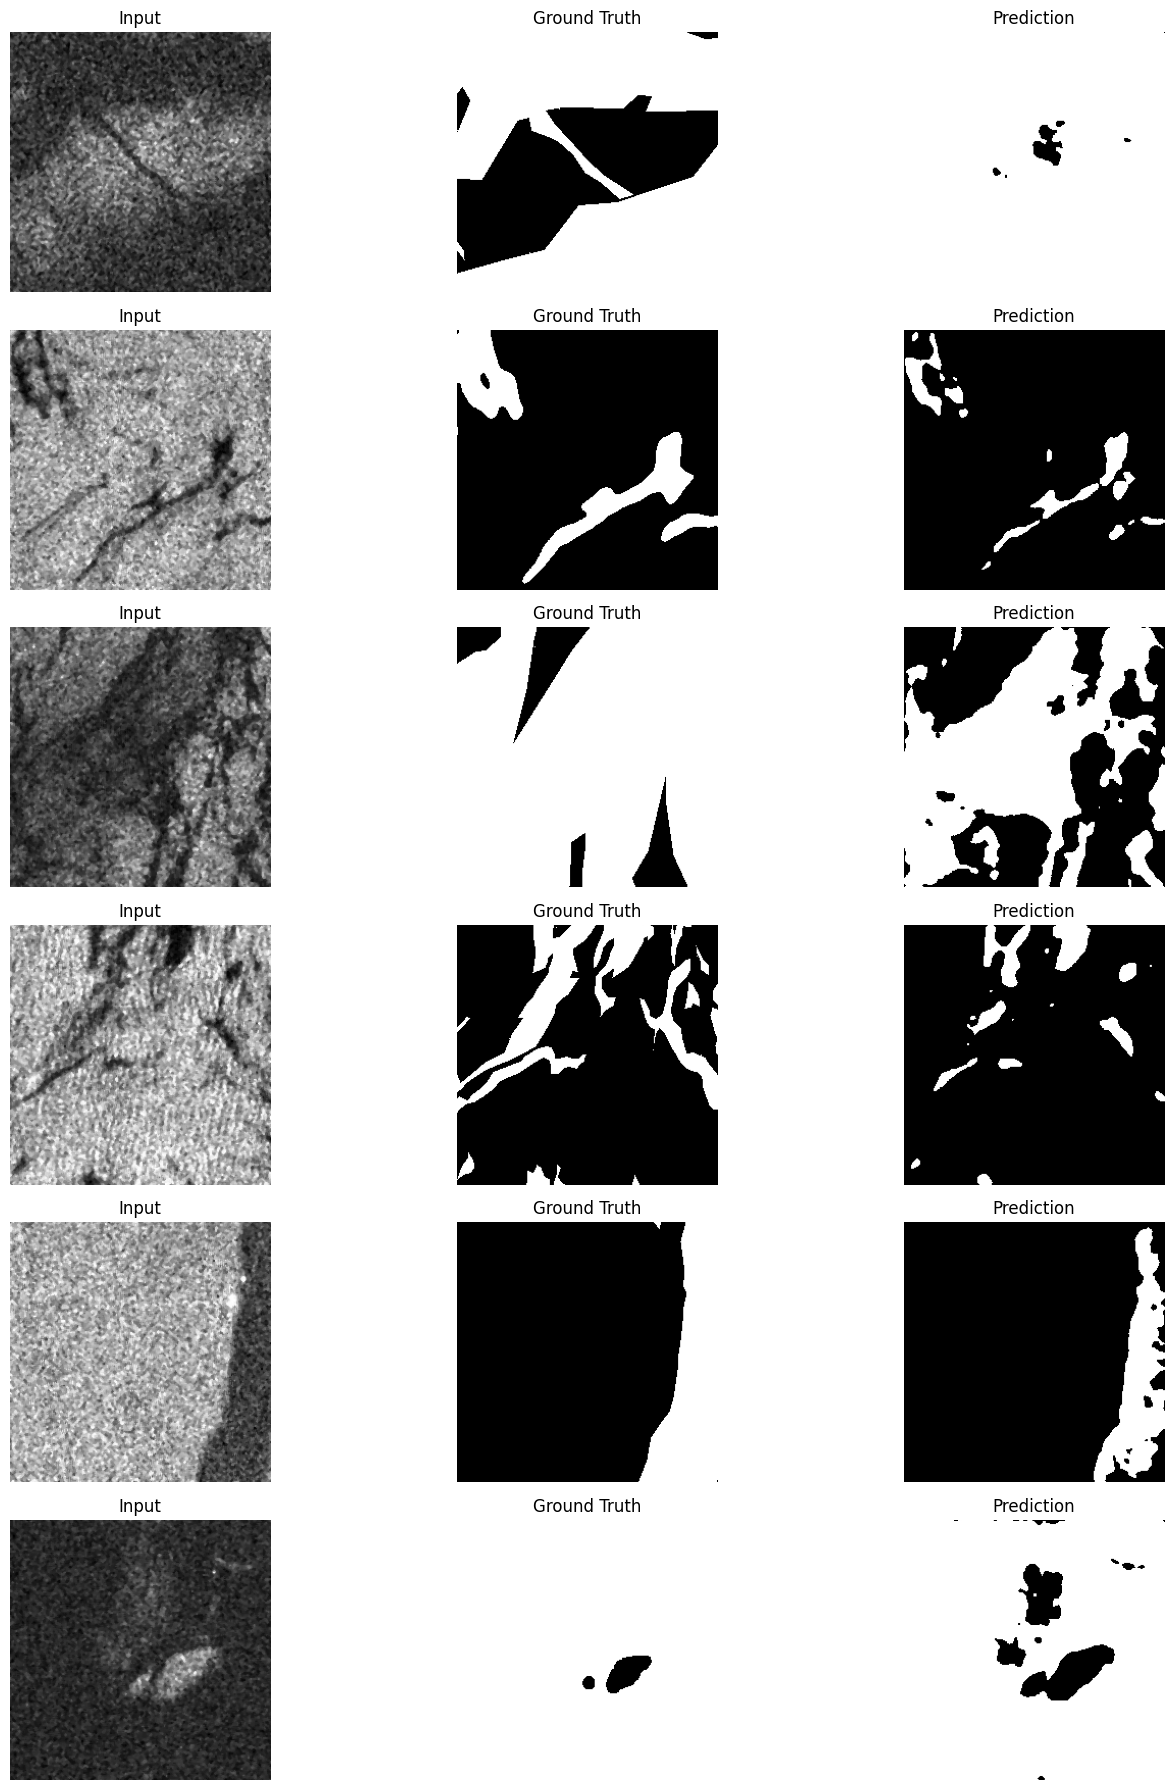

In [42]:
import matplotlib.pyplot as plt
import random

num_samples = 6
indices = random.sample(range(len(X_val)), num_samples)

plt.figure(figsize=(15, num_samples * 3))

for i, idx in enumerate(indices):
    pred = model.predict(X_val[idx:idx+1])[0]

    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(X_val[idx].squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred.squeeze() > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [43]:
import numpy as np

def dice_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)

dice_scores = []
iou_scores = []

for i in range(100):  # evaluate on 100 val images
    pred = model.predict(X_val[i:i+1])[0]
    dice_scores.append(dice_score(y_val[i], pred))
    iou_scores.append(iou_score(y_val[i], pred))

print("Mean Dice:", np.mean(dice_scores))
print("Mean IoU :", np.mean(iou_scores))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [44]:
for t in [0.3, 0.5]:
    dice_vals = []
    for i in range(50):
        pred = model.predict(X_val[i:i+1])[0]
        dice_vals.append(dice_score(y_val[i], pred, threshold=t))
    print(f"Threshold {t} → Mean Dice:", np.mean(dice_vals))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=4,
    verbose=1
)


In [1]:
import tensorflow as tf
import numpy as np
from glob import glob

train_img_paths = sorted(glob("/content/processed/train/images/*.npy"))
train_mask_paths = sorted(glob("/content/processed/train/masks/*.npy"))

val_img_paths = sorted(glob("/content/processed/val/images/*.npy"))
val_mask_paths = sorted(glob("/content/processed/val/masks/*.npy"))

def load_npy(img_path, mask_path):
    img = np.load(img_path.decode()).astype(np.float32)
    mask = np.load(mask_path.decode()).astype(np.float32)
    img = img[..., np.newaxis]
    mask = mask[..., np.newaxis]
    return img, mask

def tf_parse(img_path, mask_path):
    img, mask = tf.numpy_function(
        load_npy,
        [img_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape((256, 256, 1))
    mask.set_shape((256, 256, 1))
    return img, mask


In [2]:
BATCH_SIZE = 4

train_ds = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths))
train_ds = train_ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(200).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_img_paths, val_mask_paths))
val_ds = val_ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [3]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    verbose=1
)


NameError: name 'model' is not defined

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [6]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(
        1, 1, activation='sigmoid', dtype='float32'
    )(c7)

    return models.Model(inputs, outputs)


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model = unet_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    verbose=1
)


Epoch 1/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 170s 82ms/step - accuracy: 0.8897 - loss: 0.2756 - val_accuracy: 0.8975 - val_loss: 0.2489
Epoch 2/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 102s 63ms/step - accuracy: 0.9223 - loss: 0.1906 - val_accuracy: 0.8835 - val_loss: 0.2543
Epoch 3/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 104s 64ms/step - accuracy: 0.9245 - loss: 0.1859 - val_accuracy: 0.9009 - val_loss: 0.2331
Epoch 4/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 102s 63ms/step - accuracy: 0.9285 - loss: 0.1750 - val_accuracy: 0.9078 - val_loss: 0.2192
Epoch 5/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 102s 63ms/step - accuracy: 0.9301 - loss: 0.1710 - val_accuracy: 0.9111 - val_loss: 0.2120
Epoch 6/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 102s 63ms/step - accuracy: 0.9304 - loss: 0.1703 - val_accuracy: 0.9116 - val_loss: 0.2088
Epoch 7/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 102s 63ms/step - accuracy: 0.9327 - loss: 0.1621 - val_accuracy: 0.9125 - val_loss: 0.2108
Epoch 8/8
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 102s 63ms/step - accuracy: 0.9329 -

In [9]:
model.save("/content/unet_oil_spill_final.keras")
print("Final model saved successfully")


Final model saved successfully


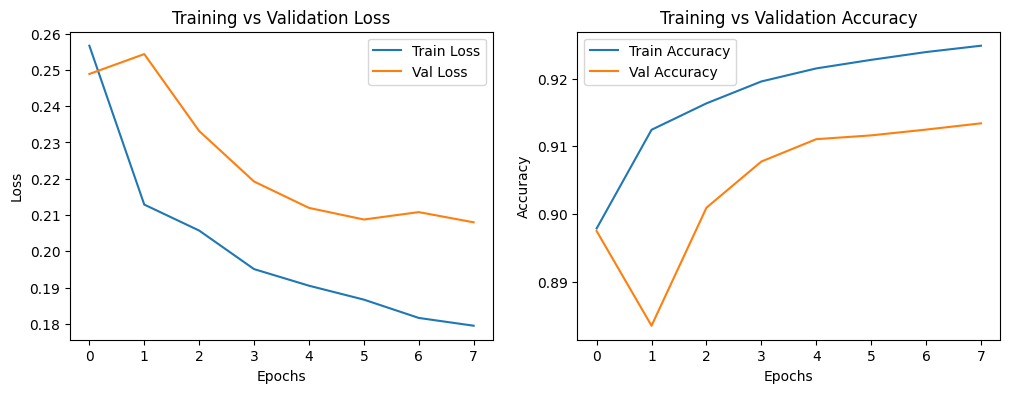

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [11]:
import numpy as np

def dice_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = y_true.astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-6)


dice_scores = []
iou_scores = []

NUM_SAMPLES = 100  # enough for evaluation

for i in range(NUM_SAMPLES):
    img = np.load(val_img_paths[i])[..., np.newaxis]
    mask = np.load(val_mask_paths[i])[..., np.newaxis]

    pred = model.predict(img[np.newaxis, ...], verbose=0)[0]

    dice_scores.append(dice_score(mask, pred))
    iou_scores.append(iou_score(mask, pred))

print("Mean Dice Score:", np.mean(dice_scores))
print("Mean IoU Score :", np.mean(iou_scores))


Mean Dice Score: 0.7000093864169041
Mean IoU Score : 0.5754171864866683


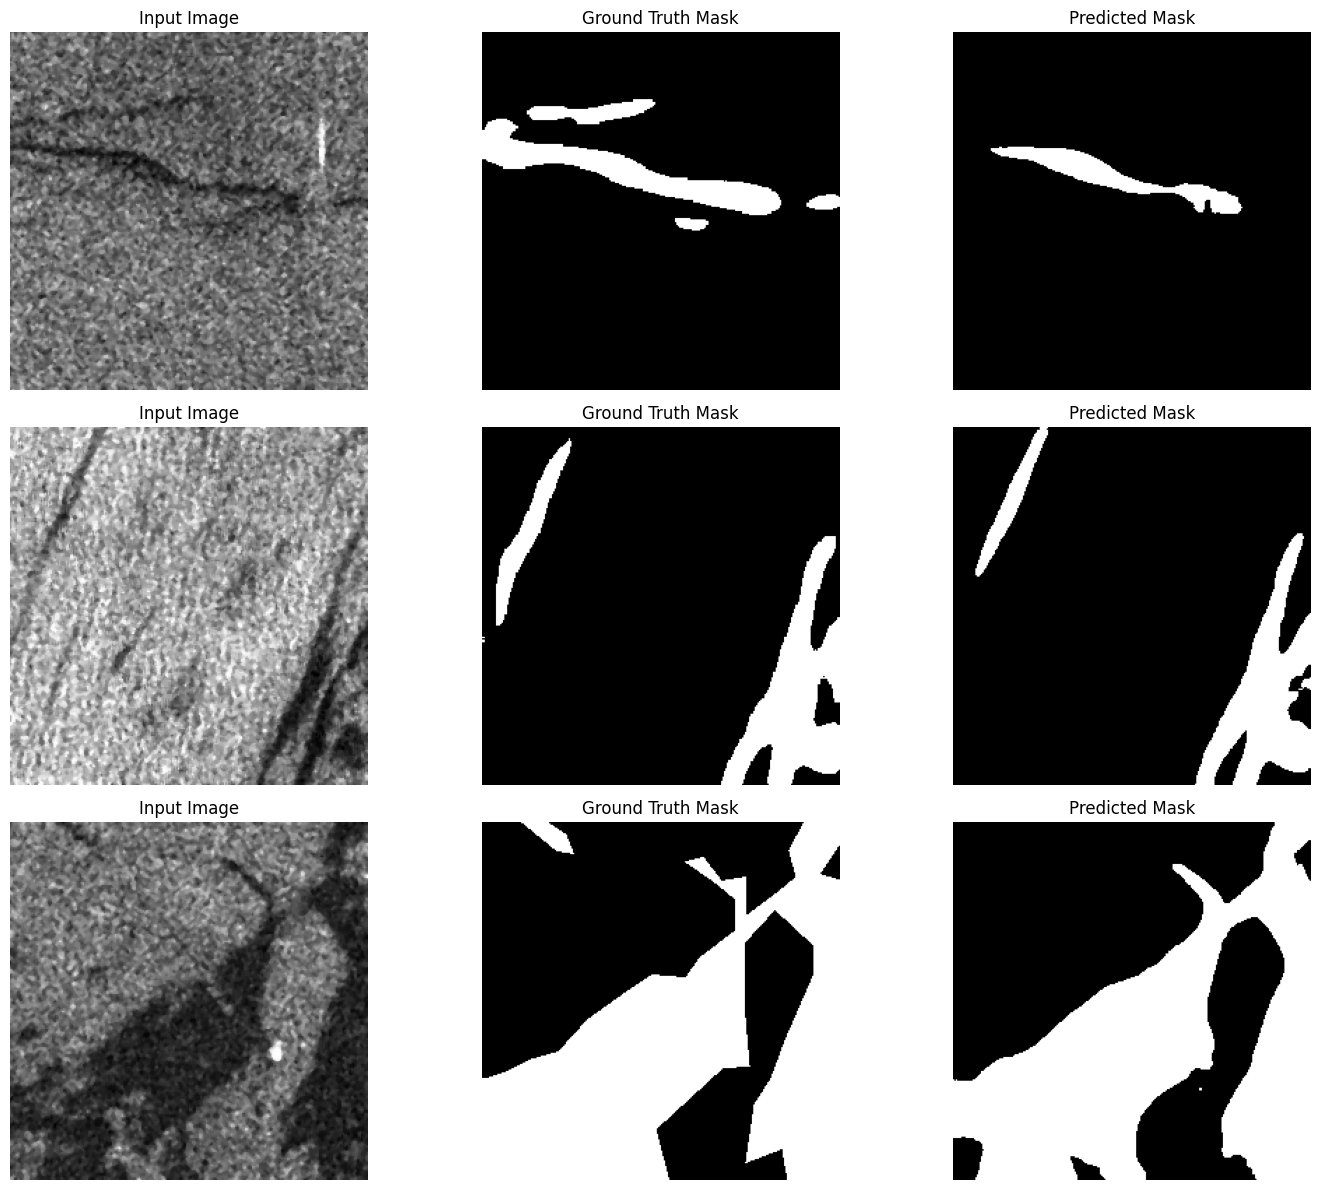

In [12]:
import matplotlib.pyplot as plt
import random

num_images = 3  # for screenshots
indices = random.sample(range(len(val_img_paths)), num_images)

plt.figure(figsize=(15, num_images * 4))

for i, idx in enumerate(indices):
    img = np.load(val_img_paths[idx])
    mask = np.load(val_mask_paths[idx])

    pred = model.predict(img[np.newaxis, ..., np.newaxis], verbose=0)[0]

    # Input image
    plt.subplot(num_images, 3, i*3 + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(num_images, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Prediction
    plt.subplot(num_images, 3, i*3 + 3)
    plt.imshow(pred.squeeze() > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
